# Data Preparation

The extracted dataset directory is arranged into a dataframe for easier manipulation

In [3]:
import os
import pandas as pd
from pathlib import Path


def list_filepaths(root):
    return [
        file.as_posix() for file in Path(root).rglob('*')
        if file.as_posix().endswith(".jpg")
    ] 

    
data = []
for file in list_filepaths(os.path.join(".", "dataset", "PetImages")):
    data.append({
        "class": "dog" if "Dog" in file else "cat",
        "filepath": file,
    })

df = pd.DataFrame(data).sample(frac=1)

## Filtering corrupted images

Some of the JPEG images in the dataset were corrupted. These exkamples should be
filtered out before splitting the datasets.

In [4]:
from tqdm import tqdm
from torchvision.io import decode_image

corrupted_images = []

for path in df["filepath"]:
    try:
        img = decode_image(path)
    except RuntimeError:
        corrupted_images.append(path)

df = df.query("filepath not in @corrupted_images")

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


## Image Showcase

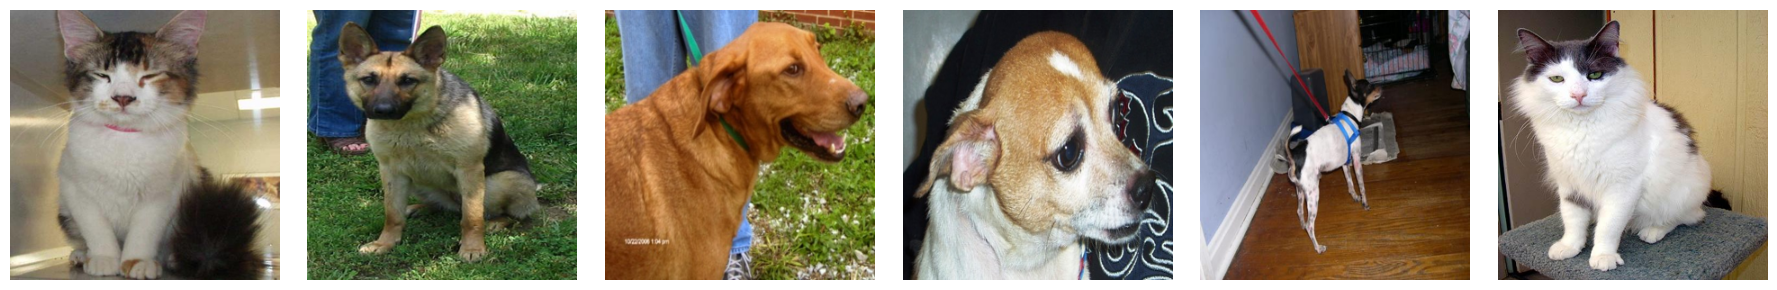

In [24]:
from PIL import Image
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 6, figsize=(18, 3))
examples = df.sample(n=6)

for path, ax in zip(examples["filepath"].tolist(), axs):
    ax.imshow(Image.open(path).resize((300, 300)))

for ax in axs:
    ax.axis("off")

fig.tight_layout()

In [26]:
fig.savefig("img/examples.jpeg")

## Set Splits

- 70% training
- 15% validation
- 15% test

Splits performed with stratification in the target class

In [5]:
from sklearn.model_selection import train_test_split

train, tmp = train_test_split(df, test_size=0.30, stratify=df['class'])
valid, test = train_test_split(tmp, test_size=0.50, stratify=tmp['class'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

## Pytorch Dataset Definition

Some of the images are stored as heic, so instead of using `decode_image` from pytorch
we are loading then with PIL and converting then to RGB. Some RGBA images in the dataset
had to go through the same transformation.

In [6]:
import cv2
from torch.utils.data import Dataset
from torchvision.io import decode_image

from PIL import Image
import torchvision.transforms.functional as TF


class DogsCatsDataset(Dataset):
    CLASS_MAPPER = {
        "cat": 0,  
        "dog": 1,  
    }
    
    def __init__(self, artifacts: pd.DataFrame, transforms=None):
        self.artifacts = artifacts
        self.transforms = transforms

    def __len__(self):
        return len(self.artifacts)

    def __getitem__(self, idx: int) -> tuple:
        item = self.artifacts.loc[idx, :].to_dict()
        img = Image.open(item["filepath"]).convert("RGB")
        img = TF.to_tensor(img)
            
        label = self.CLASS_MAPPER[item["class"]]

        if self.transforms:
            img = self.transforms(img)

        return img, label

## Extracting Pixel Statistics

- per channel mean pixel value
- per channel pixel standard deviation

In [14]:
import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader

stats_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
])

stats_loader = DataLoader(
    dataset=DogsCatsDataset(train, transforms=stats_transforms),
    batch_size=64,
    pin_memory=True,
)

acc_sum = torch.tensor([0.0, 0.0, 0.0])
acc_sum_squared = torch.tensor([0.0, 0.0, 0.0])
num_pixels = 0

for img, _ in tqdm(stats_loader):
    B, C, H, W = img.shape
    num_pixels += B * H * W
    
    acc_sum += img.sum(axis=[0, 2, 3]) 
    acc_sum_squared += (img**2).sum(axis=[0, 2, 3]) 
    
mean = acc_sum / num_pixels
std = (acc_sum_squared / num_pixels - mean**2).sqrt()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272/272 [00:27<00:00,  9.80it/s]


## Creating DataLoaders

In [15]:
import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader

train_transforms = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.RandomRotation(degrees=25),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
])

eval_transforms = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
])

train_dataset = DogsCatsDataset(artifacts=train, transforms=train_transforms)
valid_dataset = DogsCatsDataset(artifacts=valid, transforms=eval_transforms)
test_dataset = DogsCatsDataset(artifacts=test, transforms=eval_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.880123..2.0464377].


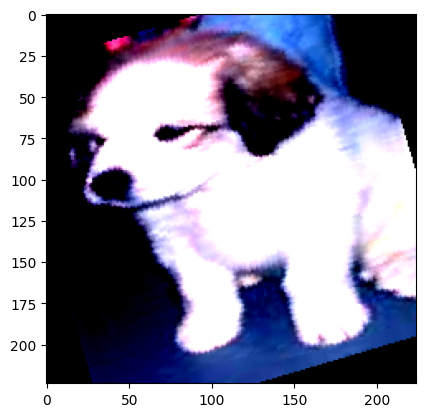

In [26]:
import matplotlib.pyplot as plt

image, label = train_dataset[7]
image = image.permute(1, 2, 0).numpy()  # Shape: [280, 350, 3]
plt.imshow(image)

# Modelling

## Model Definition

In [61]:
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torch.nn import CrossEntropyLoss, Softmax
from torch.optim import Adam


class ResNet(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)        
        self.model.fc = nn.Linear(in_features=self.model.fc.in_features, out_features=n_classes)

        for param in self.model.parameters():  # Freezingesnet parameters (transfer learning))
            param.requires_grad = False

        for param in self.model.fc.parameters():  # Unfreeze only the final fc layer
            param.requires_grad = True 
        
    def forward(self, x):
        return self.model(x)


class ModelTrainer:
    def __init__(self, model, criterion, optimizer, device):
        self.model = model.to(device)
        self.device = device
        self.criterion = criterion
        self.optimizer = optimizer

    def accuracy(self, true, pred):
        return (true == pred).sum() / len(pred)  # or len(true)

    def valid_epoch(self, valid_loader):
        self.model.eval()
        acc = []
        for x, y in valid_loader:
            x, y = x.to(self.device), y.to(self.device)
            logits = self.model(x)
            pred = torch.softmax(logits, axis=1).argmax(axis=1)
            acc.append(self.accuracy(true=y, pred=pred))
            
        return sum(acc) / len(acc)

    def train_epoch(self, dataloader):
        self.model.train()
        acc = []
        
        for x, y in tqdm(dataloader):
            x, y = x.to(self.device), y.to(self.device)
            
            self.optimizer.zero_grad()
            preds = self.model(x)
            loss = self.criterion(preds, y)
            loss.backward()
            self.optimizer.step()
            
    def train(self, dataloader, epochs, valid_loader):
        for epoch in range(epochs):
            self.train_epoch(dataloader=dataloader) 
            print("Eval: ", self.valid_epoch(valid_loader=valid_loader))

## Training

In [30]:
model = ResNet(n_classes=2)

trainer = ModelTrainer(
    model=model,
    criterion=CrossEntropyLoss(),
    optimizer=Adam(params=model.model.parameters()),
    device=torch.device("cuda")
)

In [31]:
trainer.train(dataloader=train_loader, epochs=5, valid_loader=valid_loader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272/272 [00:31<00:00,  8.52it/s]


Eval:  tensor(0.9870, device='cuda:0')


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272/272 [00:31<00:00,  8.52it/s]


Eval:  tensor(0.9876, device='cuda:0')


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272/272 [00:32<00:00,  8.39it/s]


Eval:  tensor(0.9883, device='cuda:0')


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272/272 [00:32<00:00,  8.43it/s]


Eval:  tensor(0.9870, device='cuda:0')


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272/272 [00:31<00:00,  8.68it/s]


Eval:  tensor(0.9899, device='cuda:0')


## Evaluation

In [98]:
## Sanity Check

test_images = set(test['filepath'].tolist())
train_images = set(train['filepath'].tolist())
valid_images = set(valid['filepath'].tolist())

print(test_images.intersection(train_images) == set())
print(test_images.intersection(valid_images) == set())

True
True


In [99]:
preds = []
true = []
        
for x, y in test_loader:
    x = x.to(torch.device("cuda"))
    batch_preds = torch.softmax(model(x), axis=1).argmax(axis=1).to(torch.device("cpu"))
    preds.append(batch_preds)
    true.append(y)

preds = torch.concat(preds)
true = torch.concat(true)

In [100]:
mapped_true = [list(DogsCatsDataset.CLASS_MAPPER.keys())[i.item()] for i in true]
mapped_preds = [list(DogsCatsDataset.CLASS_MAPPER.keys())[i.item()] for i in preds]

In [101]:
from sklearn.metrics import classification_report

print(classification_report(mapped_true, mapped_preds, digits=4))

              precision    recall  f1-score   support

         cat     0.9840    0.9919    0.9880      1863
         dog     0.9919    0.9838    0.9878      1856

    accuracy                         0.9879      3719
   macro avg     0.9879    0.9879    0.9879      3719
weighted avg     0.9879    0.9879    0.9879      3719



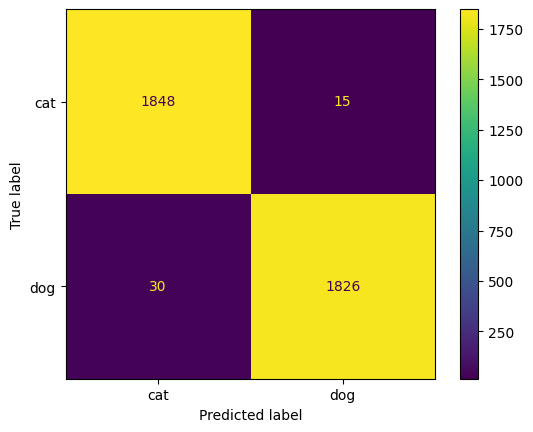

In [102]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    mapped_true, mapped_preds,
    labels=list(DogsCatsDataset.CLASS_MAPPER.keys())
)